<a href="https://colab.research.google.com/github/EmperorNao/MLHub/blob/main/DLS/sem1/HW1/knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" style="height:450px;" width=500/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>
<h3 style="text-align: center;"><b>Базовый и продвинутый потоки. Осень 2021</b></h3>

<h1 style="text-align: center;"><b>Домашнее задание. Библиотека sklearn и классификация с помощью KNN</b></h1>

На основе [курса по Машинному Обучению ФИВТ МФТИ](https://github.com/ml-mipt/ml-mipt) и [Открытого курса по Машинному Обучению](https://habr.com/ru/company/ods/blog/322626/).

---

<h2 style="text-align: center;"><b>K Nearest Neighbors (KNN)</b></h2>

Метод ближайших соседей (k Nearest Neighbors, или kNN) — очень популярный метод классификации, также иногда используемый в задачах регрессии. Это один из самых понятных подходов к классификации. На уровне интуиции суть метода такова: посмотри на соседей; какие преобладают --- таков и ты. Формально основой метода является гипотеза компактности: если метрика расстояния между примерами введена достаточно удачно, то схожие примеры гораздо чаще лежат в одном классе, чем в разных. 

<img src='https://hsto.org/web/68d/a45/6f0/68da456f00f8434e87628dbe7e3f54a7.png' width=600>


Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:

* Вычислить расстояние до каждого из объектов обучающей выборки
* Отобрать объектов обучающей выборки, расстояние до которых минимально
* Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди $k$ ближайших соседей

Будем работать с подвыборкой из [данных о типе лесного покрытия из репозитория UCI](http://archive.ics.uci.edu/ml/datasets/Covertype). Доступно 7 различных классов. Каждый объект описывается 54 признаками, 40 из которых являются бинарными. Описание данных доступно по ссылке.

### Обработка данных

In [3]:
import pandas as pd
import numpy as np

In [19]:
!wget -O forest_dataset.csv https://raw.githubusercontent.com/EmperorNao/MLHub/main/DLS/sem1/HW1/forest_dataset.csv

--2022-02-19 13:52:18--  https://raw.githubusercontent.com/EmperorNao/MLHub/main/DLS/sem1/HW1/forest_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1293856 (1.2M) [text/plain]
Saving to: ‘forest_dataset.csv’

forest_dataset.csv  100%[===================>]   1.23M  --.-KB/s    in 0.05s   

2022-02-19 13:52:18 (23.6 MB/s) - ‘forest_dataset.csv’ saved [1293856/1293856]



Сcылка на датасет (лежит в папке): https://drive.google.com/drive/folders/16TSz1P-oTF8iXSQ1xrt0r_VO35xKmUes?usp=sharing

In [22]:
all_data = pd.read_csv('forest_dataset.csv', header=None)
all_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
1,2683,333,35,30,26,2743,121,173,179,6572,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
2,2915,90,8,216,11,4433,232,228,129,4019,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,2941,162,7,698,76,2783,227,242,148,1784,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,3096,60,17,170,3,3303,231,202,99,5370,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [23]:
all_data.shape

(10001, 55)

Выделим значения метки класса в переменную `labels`, признаковые описания --- в переменную `feature_matrix`. Так как данные числовые и не имеют пропусков, переведем их в `numpy`-формат с помощью метода `.values`.

In [24]:
labels = all_data[all_data.columns[-1]].values
feature_matrix = all_data[all_data.columns[:-1]].values

### Пара слов о sklearn

**[sklearn](https://scikit-learn.org/stable/index.html)** -- удобная библиотека для знакомства с машинным обучением. В ней реализованны большинство стандартных алгоритмов для построения моделей и работ с выборками. У неё есть подробная документация на английском, с которой вам придётся поработать.

`sklearn` предпологает, что ваши выборки имеют вид пар $(X, y)$, где $X$ -- матрица признаков, $y$ -- вектор истинных значений целевой переменной, или просто $X$, если целевые переменные неизвестны.

Познакомимся со вспомогательной функцией 
[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
С её помощью можно разбить выборку на обучающую и тестовую части.

In [26]:
from sklearn.model_selection import train_test_split

Вернёмся к датасету. Сейчас будем работать со всеми 7 типами покрытия (данные уже находятся в переменных `feature_matrix` и `labels`, если Вы их не переопределили). Разделим выборку на обучающую и тестовую с помощью метода `train_test_split`.

In [27]:
train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(
    feature_matrix, labels, test_size=0.2, random_state=42)

Параметр `test_size` контролирует, какая часть выборки будет тестовой. Более подробно о нём можно прочитать в [документации](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

Основные объекты `sklearn` -- так называемые `estimators`, что можно перевести как *оценщики*, но не стоит, так как по сути это *модели*. Они делятся на **классификаторы** и **регрессоры**.

В качестве примера модели можно привести классификаторы
[метод ближайших соседей](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) и 
[логистическую регрессию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Что такое логистическая регрессия и как она работает сейчас не важно.

У всех моделей в `sklearn` обязательно должно быть хотя бы 2 метода (подробнее о методах и классах в python будет в следующих занятиях) -- `fit` и `predict`.

Метод `fit(X, y)` отвечает за обучение модели и принимает на вход обучающую выборку в виде *матрицы признаков* $X$ и *вектора ответов* $y$.

У обученной после `fit` модели теперь можно вызывать метод `predict(X)`, который вернёт предсказания этой модели на всех объектах из матрицы $X$ в виде вектора.

Вызывать `fit` у одной и той же модели можно несколько раз, каждый раз она будет обучаться заново на переданном наборе данных.

Ещё у моделей есть *гиперпараметры*, которые обычно задаются при создании модели.

Рассмотрим всё это на примере логистической регрессии.

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
# создание модели с указанием гиперпараметра C
clf = LogisticRegression(C=1)
# обучение модели
clf.fit(train_feature_matrix, train_labels)
# предсказание на тестовой выборке
y_pred = clf.predict(test_feature_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Теперь хотелось бы измерить качество нашей модели. Для этого можно использовать метод `score(X, y)`, который посчитает какую-то функцию ошибки на выборке $X, y$, но какую конкретно уже зависит от модели. Также можно использовать одну из функций модуля `metrics`, например [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), которая, как понятно из названия, вычислит нам точность предсказаний.

In [30]:
from sklearn.metrics import accuracy_score

accuracy_score(test_labels, y_pred)

0.6256871564217891

Наконец, последним, о чём хотелось бы упомянуть, будет перебор гиперпараметров по сетке. Так как у моделей есть много гиперпараметров, которые можно изменять, и от этих гиперпараметров существенно зависит качество модели, хотелось бы найти наилучшие в этом смысле параметры. Самый простой способ это сделать -- просто перебрать все возможные варианты в разумных пределах.

Сделать это можно с помощью класса [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), который осуществляет поиск (search) по сетке (grid) и вычисляет качество модели с помощью кросс-валидации (CV).

У логистической регрессии, например, можно поменять параметры `C` и `penalty`. Сделаем это. Учтите, что поиск может занять долгое время. Смысл параметров смотрите в документации.

In [31]:
from sklearn.model_selection import GridSearchCV

In [34]:
# заново создадим модель, указав солвер
clf = LogisticRegression(solver='saga')

# опишем сетку, по которой будем искать
param_grid = {
    'C': np.arange(1, 5), # также можно указать обычный массив, [1, 2, 3, 4]
    'penalty': ['l1', 'l2'],
}

# создадим объект GridSearchCV
search = GridSearchCV(clf, param_grid, n_jobs=-1, refit=True, scoring='accuracy')

# запустим поиск
search.fit(feature_matrix, labels)

# выведем наилучшие параметры
print(search.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


{'C': 2, 'penalty': 'l2'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


В данном случае, поиск перебирает все возможные пары значений C и penalty из заданных множеств.

In [35]:
accuracy_score(labels, search.best_estimator_.predict(feature_matrix))

0.6418358164183582

Заметьте, что мы передаём в GridSearchCV всю выборку, а не только её обучающую часть. Это можно делать, так как поиск всё равно использует кроссвалидацию. Однако порой от выборки всё-же отделяют *валидационную* часть, так как гиперпараметры в процессе поиска могли переобучиться под выборку.

В заданиях вам предстоит повторить это для метода ближайших соседей.

### Обучение модели

Качество классификации/регрессии методом ближайших соседей зависит от нескольких параметров:

* число соседей `n_neighbors`
* метрика расстояния между объектами `metric`
* веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос") `weights`


Обучите на датасете `KNeighborsClassifier` из `sklearn`.

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

clf = KNeighborsClassifier()

clf.fit(train_feature_matrix, train_labels)
y_pred = clf.predict(test_feature_matrix)
accuracy_score(test_labels, y_pred)

0.7391304347826086

### Вопрос 1:
* Какое качество у вас получилось?

0.7391

Подберём параметры нашей модели

* Переберите по сетке от `1` до `10` параметр числа соседей

* Также вы попробуйте использоввать различные метрики: `['manhattan', 'euclidean']`

* Попробуйте использовать различные стратегии вычисления весов: `[‘uniform’, ‘distance’]`

In [38]:
from sklearn.model_selection import GridSearchCV
params = {
    'n_neighbors': np.arange(1, 11),
    'metric': ['manhattan', 'euclidean'],
    'weights': ['uniform', 'distance']
}

# создадим объект GridSearchCV
search = GridSearchCV(clf, params, n_jobs=-1, refit=True, scoring='accuracy')

# запустим поиск
search.fit(feature_matrix, labels)

# выведем наилучшие параметры
print(search.best_params_)

clf_grid = GridSearchCV(clf, params, cv=5, scoring='accuracy', n_jobs=-1)
# Теперь обучение. Ваш код здесь

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


Выведем лучшие параметры

In [42]:
search.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

### Вопрос 2:
* Какую metric следует использовать?

manhattan

### Вопрос 3:
* Сколько n_neighbors следует использовать?

4

### Вопрос 4:
* Какой тип weights следует использовать?

distance

Используя найденное оптимальное число соседей, вычислите вероятности принадлежности к классам для тестовой выборки (`.predict_proba`).

In [47]:
optimal_clf = KNeighborsClassifier(n_neighbors=4, weights='distance', metric='manhattan')
optimal_clf.fit(feature_matrix, labels)

pred_prob = optimal_clf.predict_proba(test_feature_matrix)

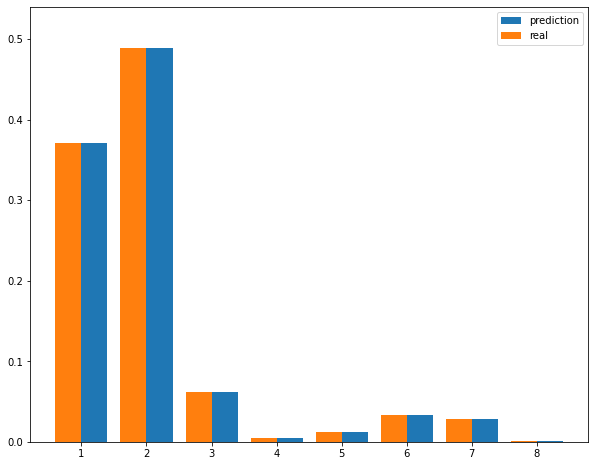

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

unique, freq = np.unique(test_labels, return_counts=True)
freq = list(map(lambda x: x / len(test_labels),freq))

pred_freq = pred_prob.mean(axis=0)
plt.figure(figsize=(10, 8))
plt.bar(range(1, len(unique) + 1), pred_freq, width=0.4, align="edge", label='prediction')
plt.bar(range(1, len(unique) + 1), freq, width=-0.4, align="edge", label='real')
plt.ylim(0, 0.54)
plt.legend()
plt.show()

### Вопрос 5:
* Какая прогнозируемая вероятность pred_freq класса под номером 3 (до 2 знаков после запятой)?

0.05